# Adversarial Variational Optimization: Poisson benchmark

This notebook shows the usage of `cag` with `AVO` (Adversarial Variational Optimization) on the Poisson benchmark. In this inference setting, the goal is to obtain the model parameter $\mathbf{\theta}*$ that is responsible for generating $\mathbf{x}_o \sim p(\mathbf{x}|\mathbf{\theta})$.

In [1]:
import numpy as np
import torch
import cag
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

First, we need to be in the possesion of some $\mathbf{x}_o$:

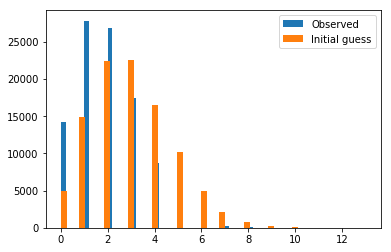

In [2]:
from cag.benchmark.poisson import allocate_observations

theta_true, x_o = allocate_observations(1.95)

# Show some observation, with some initial guess.z
plt.hist(x_o.numpy(), bins=50, label="Observed")
plt.hist(allocate_observations(3.)[1].numpy(), bins=50, label="Initial guess")
plt.legend()
plt.show()

Clearly, our initial guess is completely wrong.

## Utility methods

In [3]:
def plot_proposal(proposal):
    mean = proposal._mu.item()
    sigma = proposal._sigma.item()
    true = theta_true.item()
    x = np.linspace(mean - 15 * sigma, mean + 15 * sigma + 1.5, 5000)
    plt.axvline(true, linestyle="--", c="lightgray", label=r"${\theta^*}$")
    plt.plot(x, mlab.normpdf(x, mean, sigma), label=r"$q({\theta}|{\psi})\ \gamma = 0$")
    plt.xlim([0, np.max(x)])
    plt.grid(False)
    plt.legend()
    plt.show()

## AVO

### Discriminator

In [4]:
def allocate_discriminator():
    num_hidden = 50
    discriminator = torch.nn.Sequential(
        torch.nn.Linear(1, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.PReLU(),
        torch.nn.Linear(num_hidden, 1),
        torch.nn.Sigmoid()
    )
    
    return discriminator

### Simulator

In [5]:
from cag.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

### Proposal

In [6]:
from cag.proposal import NormalProposal

proposal = NormalProposal()

### Inference

In [7]:
from cag.inference import AdversarialVariationalOptimization

avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal)

In [ ]:
proposal = avo.infer(x_o, num_steps=5000)

In [ ]:
plot_proposal(proposal)

## Ensemble AVO

In [8]:
from cag.nn import Ensemble

num_models = 10
ensemble_discriminator = Ensemble(allocate_discriminator, num_models)

### Inference

In [9]:
# Allocate a new proposal.
proposal = NormalProposal()

avo = AdversarialVariationalOptimization(simulator, ensemble_discriminator, proposal)

In [10]:
proposal = avo.infer(x_o, num_steps=5000)

/home/joeri/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


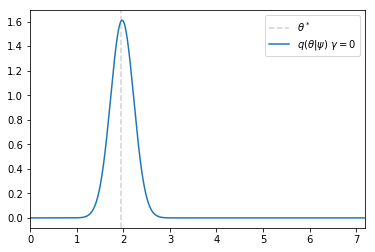

In [11]:
plot_proposal(proposal)

## Experiment: effect of ensembles

In [12]:
num_experiments = 20

### No ensemble

In [16]:
no_ensembles = []

for experiment in range(num_experiments):
    proposal = NormalProposal()
    avo = AdversarialVariationalOptimization(simulator, allocate_discriminator(), proposal)
    proposal = avo.infer(x_o, num_steps=5000)
    distance_to_truth = (proposal._mu - theta_true).abs().item()
    no_ensembles.append(distance_to_truth)
    print("Experiment", (experiment + 1), ':', distance_to_truth)
    
no_ensembles = np.array(no_ensembles)

print("Average distance with a single discriminator:", np.mean(no_ensembles))
print("Std with a single discriminator", np.std(no_ensembles))

Average distance with a single discriminator: 0.031431710720062254
Std with a single discriminator 0.02099153095332275


### With ensemble

In [ ]:
with_ensembles = {}
ensembles = [2, 4, 8, 16, 32]

for num_ensembles in ensembles:
    with_ensembles[num_ensembles] = []
    for experiment in range(num_experiments):
        proposal = NormalProposal()
        ensemble = Ensemble(allocate_discriminator, num_ensembles)
        avo = AdversarialVariationalOptimization(simulator, ensemble, proposal)
        proposal = avo.infer(x_o, num_steps=5000)
        distance_to_truth = (proposal._mu - theta_true).abs().item()
        with_ensembles[num_ensembles].append(distance_to_truth)
    with_ensembles[num_ensembles] = np.array(with_ensembles[num_ensembles])
    print("Average distance with", num_ensembles, "ensembles:", np.mean(with_ensembles[num_ensembles]))
    print("Std with", num_ensembles, "ensembles:", np.std(with_ensembles[num_ensembles]))

Average distance with 2 ensembles: 0.04862644672393799
Std with 2 ensembles: 0.0359776774302251


### Summary